# Example: Feature engineering
------------------------------

This example shows how to use automated feature generation to improve a model's performance.

The data used is a variation on the [Australian weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) from Kaggle. You can download it from [here](https://github.com/tvdboom/ATOM/blob/master/examples/datasets/weatherAUS.csv). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look
X.head()

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  MelbourneAirport     18.0     26.9      21.4          7.0       8.9   
1          Adelaide     17.2     23.4       0.0          NaN       NaN   
2            Cairns     18.6     24.6       7.4          3.0       6.1   
3          Portland     13.6     16.8       4.2          1.2       0.0   
4           Walpole     16.4     19.9       0.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Humidity9am  \
0         SSE           41.0          W        SSE  ...         95.0   
1           S           41.0          S        WSW  ...         59.0   
2         SSE           54.0        SSE         SE  ...         78.0   
3         ESE           39.0        ESE        ESE  ...         76.0   
4          SE           44.0         SE         SE  ...         78.0   

   Humidity3pm  Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  \
0         54.0       1019.5       1017.0       8.0       5.0     18.5   
1         36.0       1015.7       1015.7       NaN       NaN     17.7   
2         57.0       1018.7       1016.6       3.0       3.0     20.8   
3         74.0       1021.4       1020.5       7.0       8.0     15.6   
4         70.0       1019.4       1018.9       NaN       NaN     17.4   

   Temp3pm  RainToday  RainTomorrow  
0     26.0        Yes             0  
1     21.9         No             0  
2     24.1        Yes             0  
3     16.0        Yes             1  
4     18.1         No             0  

[5 rows x 22 columns]

## Run the pipeline

In [3]:
# Initialize atom and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, verbose=0)
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)
atom.encode(max_onehot=10, infrequent_to_value=0.04)

In [4]:
atom.verbose = 2  # Increase verbosity to see the output

# Let's see how a LightGBM model performs
atom.run('LGB', metric='auc')


Training ========================= >>
Models: LGB
Metric: auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> auc: 0.9817
Test evaluation --> auc: 0.8584
Time elapsed: 0.831s
-------------------------------------------------
Time: 0.831s


Final results ==================== >>
Total time: 0.963s
-------------------------------------
LightGBM --> auc: 0.8584


## Deep Feature Synthesis

In [5]:
# Since we are going to compare different datasets,
# we need to create separate branches
atom.branch = "dfs"

Successfully created new branch: dfs.


In [6]:
# Create 50 new features using dfs
atom.feature_generation("dfs", n_features=50, operators=["add", "sub", "log"])

Fitting FeatureGenerator...
Generating new features...
 --> 50 new features were added.


In [7]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the nans attribute
atom.nans

Location                       0
MinTemp                        0
MaxTemp                        0
Rainfall                       0
Evaporation                    0
                              ..
Temp9am - WindDir3pm           0
WindDir9am + WindGustSpeed     0
WindDir9am + WindSpeed3pm      0
WindGustDir + WindSpeed9am     0
WindSpeed3pm - WindSpeed9am    0
Length: 73, dtype: int64

In [8]:
# Turn off warnings in the future
atom.warnings = False

# Impute the data again to get rid of the missing values
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)

Fitting Imputer...
Imputing missing values...
 --> Imputing 12 missing values using the KNN imputer in feature NATURAL_LOGARITHM(Temp3pm).


In [9]:
# 50 new features may be to much...
# Let's check for multicollinearity and use rfecv to reduce the number
atom.feature_selection(
    strategy="rfecv",
    solver="LGB",
    n_features=30,
    scoring="auc",
    max_correlation=0.98,
)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature MinTemp was removed due to collinearity with another feature.
 --> Feature MinTemp + RainToday_No was removed due to collinearity with another feature.
 --> Feature MaxTemp was removed due to collinearity with another feature.
 --> Feature MaxTemp + WindDir3pm was removed due to collinearity with another feature.
 --> Feature MaxTemp + WindGustDir was removed due to collinearity with another feature.
 --> Feature Rainfall was removed due to collinearity with another feature.
 --> Feature Rainfall + RainToday_rare was removed due to collinearity with another feature.
 --> Feature Rainfall + WindDir3pm was removed due to collinearity with another feature.
 --> Feature Sunshine was removed due to collinearity with another feature.
 --> Feature Sunshine - WindDir3pm was removed due to collinearity with another feature.
 --> Feature WindGustSpeed was removed due to collinearity with another feature.
 --> Feature WindSp

In [10]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear_

drop  \
0                          MinTemp   
1           MinTemp + RainToday_No   
2                          MaxTemp   
3             MaxTemp + WindDir3pm   
4            MaxTemp + WindGustDir   
5                         Rainfall   
6        Rainfall + RainToday_rare   
7            Rainfall + WindDir3pm   
8                         Sunshine   
9            Sunshine - WindDir3pm   
10                   WindGustSpeed   
11                    WindSpeed9am   
12                    WindSpeed3pm   
13                     Humidity9am   
14                     Humidity3pm   
15  NATURAL_LOGARITHM(Pressure3pm)   
16     Pressure3pm - RainToday_Yes   
17         Cloud9am + RainToday_No   
18                        Cloud3pm   
19             Cloud3pm + Location   
20            Temp9am - WindDir3pm   
21                         Temp3pm   
22            Temp3pm - WindDir9am   
23                  RainToday_rare   

                                         corr_feature              corr_value  
0     MinTemp + RainToday_No, MinTemp + RainToday_Yes          0.9978, 0.9979  
1                    MinTemp, MinTemp + RainToday_Yes          0.9978, 0.9914  
2   MaxTemp + WindDir3pm, MaxTemp + WindDir9am, Ma...           1.0, 1.0, 1.0  
3   MaxTemp, MaxTemp + WindDir9am, MaxTemp + WindG...           1.0, 1.0, 1.0  
4   MaxTemp, MaxTemp + WindDir3pm, MaxTemp + WindD...           1.0, 1.0, 1.0  
5   Rainfall + RainToday_Yes, Rainfall + RainToday...      0.999, 0.9999, 1.0  
6   Rainfall, Rainfall + RainToday_Yes, Rainfall +...  0.9999, 0.9989, 0.9999  
7   Rainfall, Rainfall + RainToday_Yes, Rainfall +...      1.0, 0.999, 0.9999  
8    RainToday_rare + Sunshine, Sunshine - WindDir3pm          0.9994, 0.9998  
9                 Sunshine, RainToday_rare + Sunshine          0.9998, 0.9993  
10                         WindDir9am + WindGustSpeed                     1.0  
11                         WindGustDir + WindSpeed9am                     1.0  
12                          WindDir9am + WindSpeed3pm                     1.0  
13                          Humidity9am + WindGustDir                     1.0  
14                             Humidity3pm - Sunshine                  0.9937  
15           Pressure3pm, Pressure3pm - RainToday_Yes             1.0, 0.9981  
16        Pressure3pm, NATURAL_LOGARITHM(Pressure3pm)          0.9981, 0.9981  
17                                           Cloud9am                  0.9828  
18     Cloud3pm + Location, Cloud3pm + RainToday_rare             1.0, 0.9991  
19                Cloud3pm, Cloud3pm + RainToday_rare             1.0, 0.9991  
20                                            Temp9am                     1.0  
21     RainToday_rare + Temp3pm, Temp3pm - WindDir9am             0.9999, 1.0  
22                  Temp3pm, RainToday_rare + Temp3pm             1.0, 0.9999  
23                          Location + RainToday_rare                     1.0

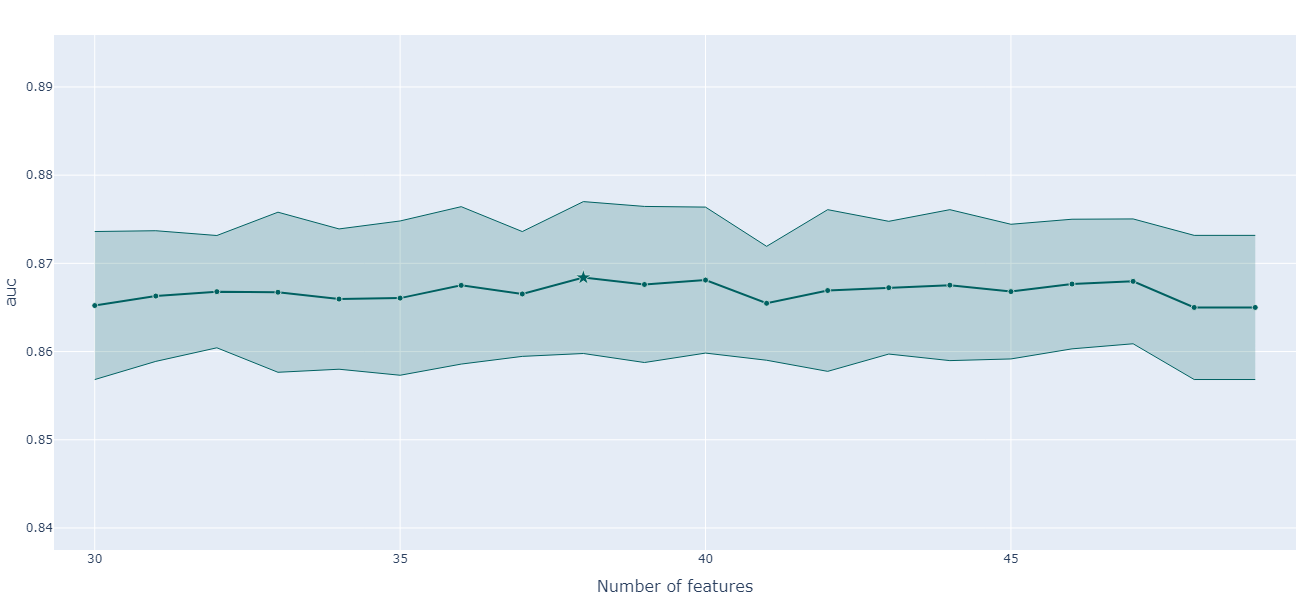

In [11]:
# After applying rfecv, we can plot the score per number of features
atom.plot_rfecv()

In [12]:
# Let's see how the model performs now
# Add a tag to the model's acronym to not overwrite previous LGB
atom.run("LGB_dfs", errors="raise")


Training ========================= >>
Models: LGB_dfs
Metric: auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> auc: 0.9893
Test evaluation --> auc: 0.8572
Time elapsed: 1.045s
-------------------------------------------------
Time: 1.045s


Final results ==================== >>
Total time: 1.186s
-------------------------------------
LightGBM --> auc: 0.8572


## Genetic Feature Generation

In [13]:
# Create another branch for the genetic features
# Split form master to avoid the dfs features
atom.branch = "gfg_from_main"

Successfully created new branch: gfg.


In [14]:
# Create new features using Genetic Programming
atom.feature_generation(strategy='gfg', n_features=20)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.08         0.137852        3         0.505879              N/A     18.62s
   1     3.30         0.332951        6         0.506041              N/A     19.23s
   2     3.92         0.429317        7         0.525775              N/A     18.31s
   3     4.64         0.459817        9         0.532823              N/A     16.25s
   4     6.59         0.475058       11         0.540078              N/A     15.51s
   5     8.04         0.498345       13          0.54114              N/A     14.56s
   6     9.80         0.509423       13         0.543911              N/A     13.87s
   7    10.86         0.513225       15         0.551242              N/A     13.28s
   8    11.54         0.513973       15        

In [16]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features_

name                                        description   fitness
0   x23  mul(add(WindGustSpeed, Humidity3pm), mul(add(C...  0.541449
1   x24  mul(add(Cloud3pm, add(Cloud3pm, mul(Humidity3p...  0.541449
2   x25  mul(add(Cloud3pm, add(Cloud3pm, mul(Humidity3p...  0.541449
3   x26  mul(add(WindGustSpeed, Humidity3pm), mul(add(C...  0.541449
4   x27  mul(add(WindGustSpeed, Humidity3pm), mul(add(C...  0.541449
5   x28  mul(add(Cloud3pm, add(Cloud3pm, mul(add(WindGu...  0.541322
6   x29  mul(add(Cloud3pm, mul(Humidity3pm, WindDir3pm)...  0.541229
7   x30  mul(add(Cloud3pm, mul(Humidity3pm, WindDir3pm)...  0.541229
8   x31  mul(add(Cloud3pm, mul(Humidity3pm, WindDir3pm)...  0.540696
9   x32  mul(add(Cloud3pm, add(Cloud3pm, mul(Humidity3p...  0.540674
10  x33  mul(add(WindGustSpeed, Humidity3pm), mul(add(C...  0.540674
11  x34  mul(add(Cloud3pm, add(Cloud3pm, mul(Humidity3p...  0.540674
12  x35  mul(add(Cloud3pm, add(Cloud3pm, mul(Humidity3p...  0.540281
13  x36  mul(add(Cloud3pm, add(Cloud3pm, mul(Humidity3p...  0.540281
14  x37  mul(add(Cloud3pm, add(Cloud3pm, mul(Humidity3p...  0.539923
15  x38  mul(add(Cloud3pm, add(Cloud3pm, mul(Humidity3p...  0.539923
16  x39  mul(add(WindGustSpeed, add(Humidity3pm, Rainfa...  0.539923
17  x40  mul(add(WindGustSpeed, Humidity3pm), mul(add(C...  0.539923
18  x41  mul(mul(add(Cloud3pm, add(Cloud3pm, mul(Humidi...  0.539923
19  x42  mul(add(Cloud3pm, add(Cloud3pm, mul(Humidity3p...  0.539909

In [17]:
# Fit the model again
atom.run("LGB_gfg", metric="auc")


Training ========================= >>
Models: LGB_gfg
Metric: auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> auc: 0.9857
Test evaluation --> auc: 0.8558
Time elapsed: 1.044s
-------------------------------------------------
Time: 1.044s


Final results ==================== >>
Total time: 1.227s
-------------------------------------
LightGBM --> auc: 0.8558


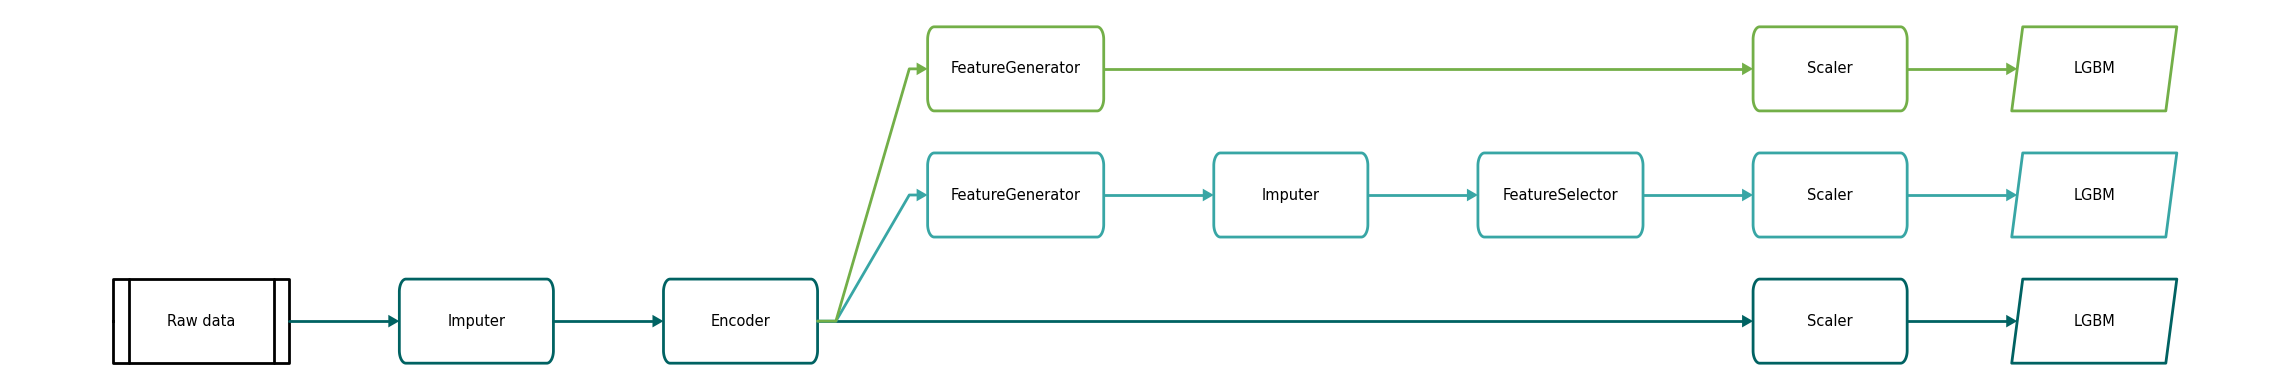

In [18]:
# Visualize the whole pipeline
atom.plot_pipeline()

## Analyze the results

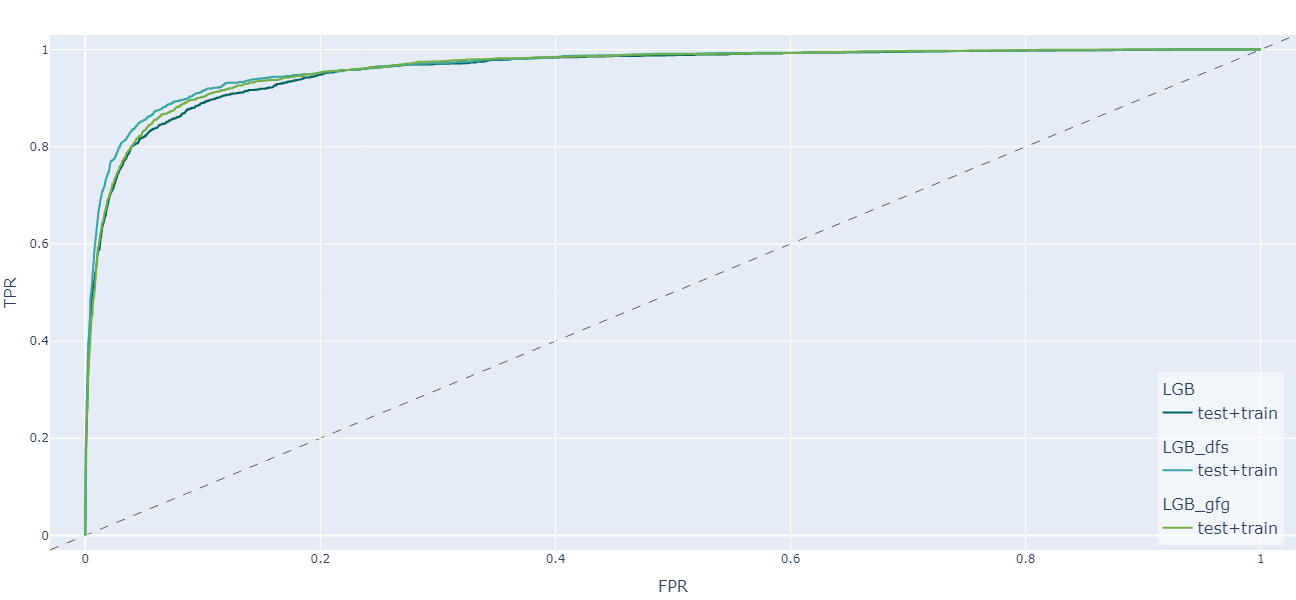

In [19]:
# Use atom's plots to compare the three models
atom.plot_roc(rows="test+train")

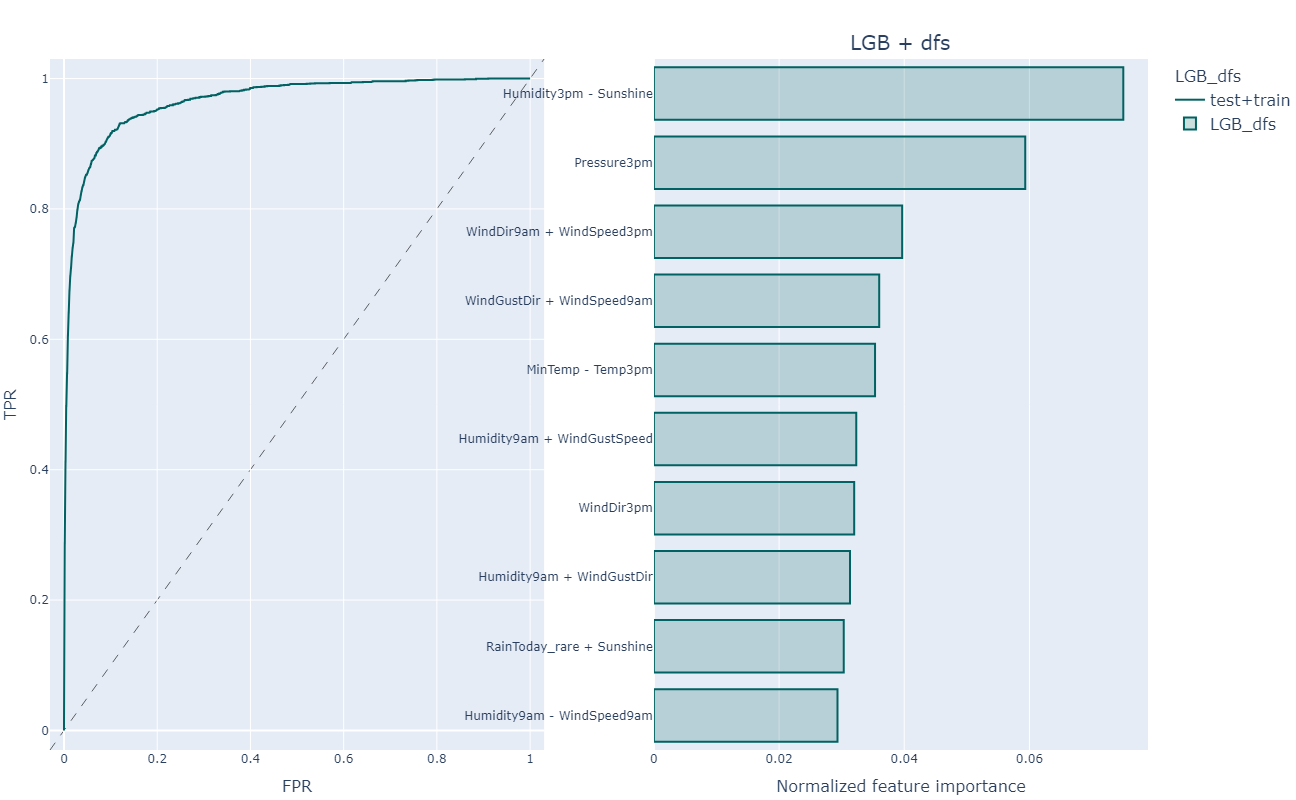

In [23]:
# To compare other plots it might be useful to use a canvas
with atom.canvas(1, 2, figsize=(1800, 800)):
    atom.lgb_dfs.plot_roc(rows="test+train")
    atom.lgb_dfs.plot_feature_importance(show=10, title="LGB + dfs")

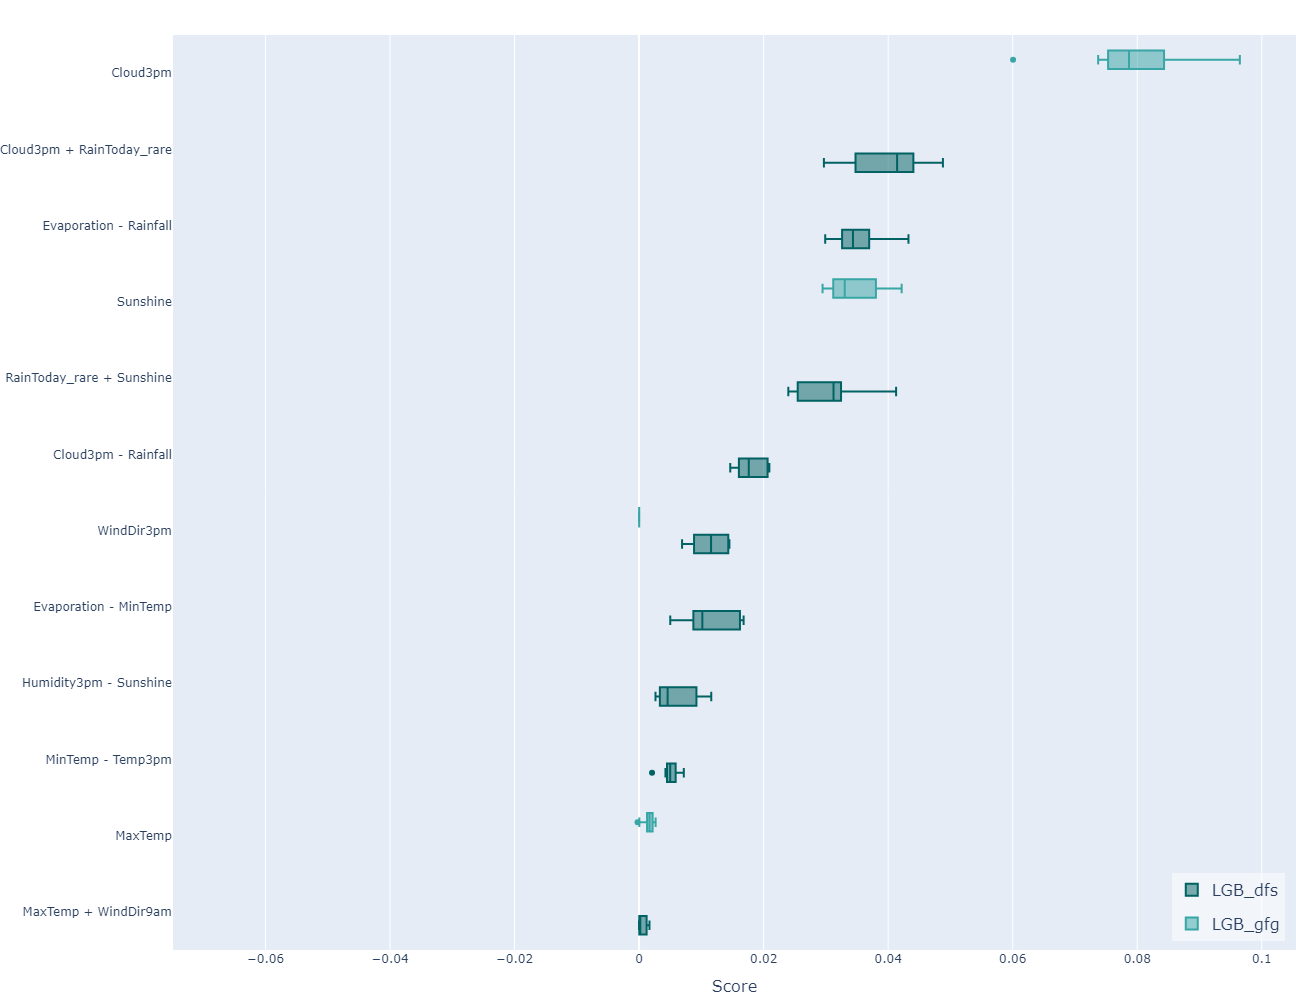

In [21]:
# We can check the feature importance with other plots as well
atom.plot_permutation_importance(models=["LGB_dfs", "LGB_gfg"], show=12)

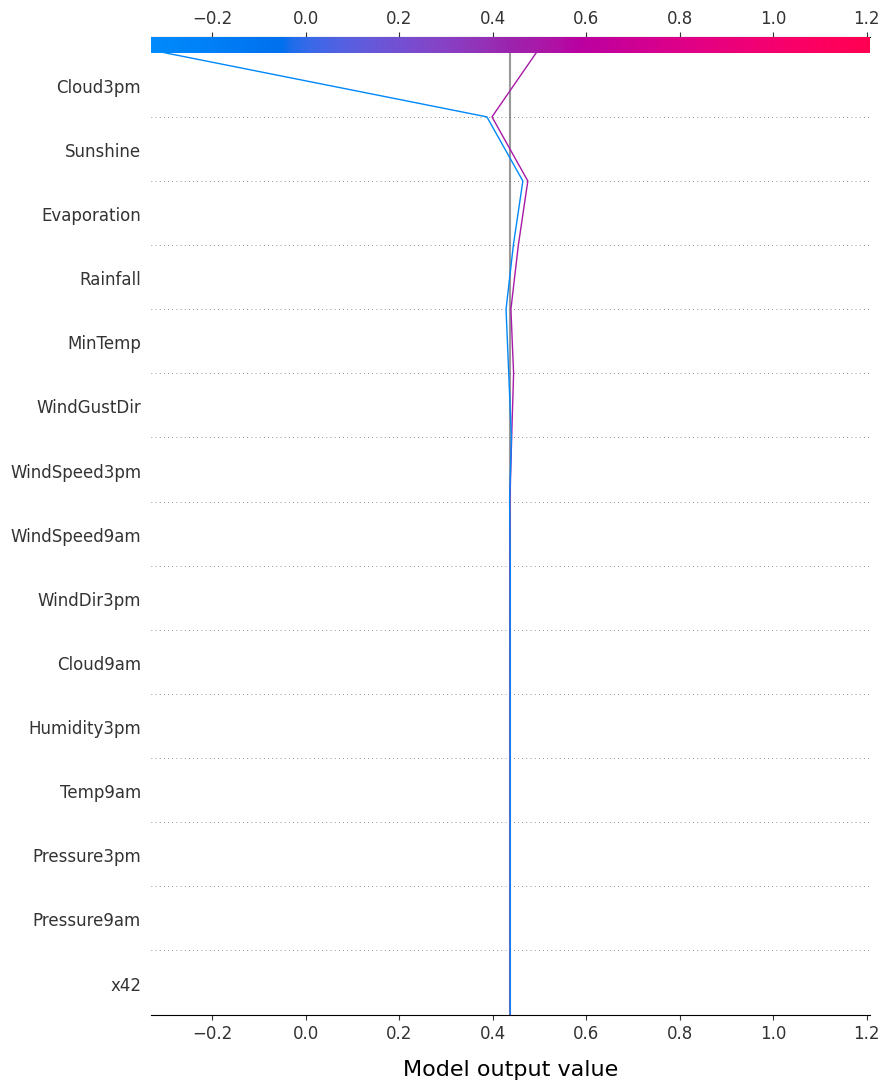

In [24]:
atom.LGB_gfg.plot_shap_decision(rows=(0, 10), show=15)